# Packages

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas_datareader as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# Read Data

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
out_path = os.path.join(parent_path, "out")

if os.path.exists(data_path) == False: os.makedirs(data_path)
if os.path.exists(out_path) == False: os.makedirs(out_path)

In [3]:
df_yf = pd.read_parquet(
    path = os.path.join(data_path, "yf.parquet"),
    engine = "pyarrow")

df_corr = pd.read_parquet(
    path = os.path.join(data_path, "corr.parquet"))

# Try again at adding the correlation back to the VIX

In [115]:
df_corr_constant = (df_corr.drop(
    columns = ["field"]).
    assign(
        ticker = lambda x: x.ticker.str.split(" ").str[0],
        multiply_constant = lambda x: ((100 - x.value) / 100) + 1).
    drop(columns = ["value"]))

df_vix_corr = (df_yf.query(
    "variable == 'VIX'").
    merge(df_corr_constant, how = "inner", on = ["date"]).
    assign(new_vol = lambda x: x.multiply_constant * x.value))

df_combined = (df_yf.query(
    "variable == 'MOVE'").
    drop(columns = ["variable"]).
    rename(columns = {"value": "MOVE"}).
    merge(df_vix_corr, how = "inner", on = ["date"])
    [["date", "MOVE", "new_vol"]].
    set_index("date"))

In [116]:
df_all_three = (df_yf.pivot(
    index = "date", columns = "variable", values = "value").
    reset_index().
    merge(df_vix_corr, how = "inner", on = ["date"])
    [["date", "MOVE", "VIX", "new_vol"]].
    set_index("date"))

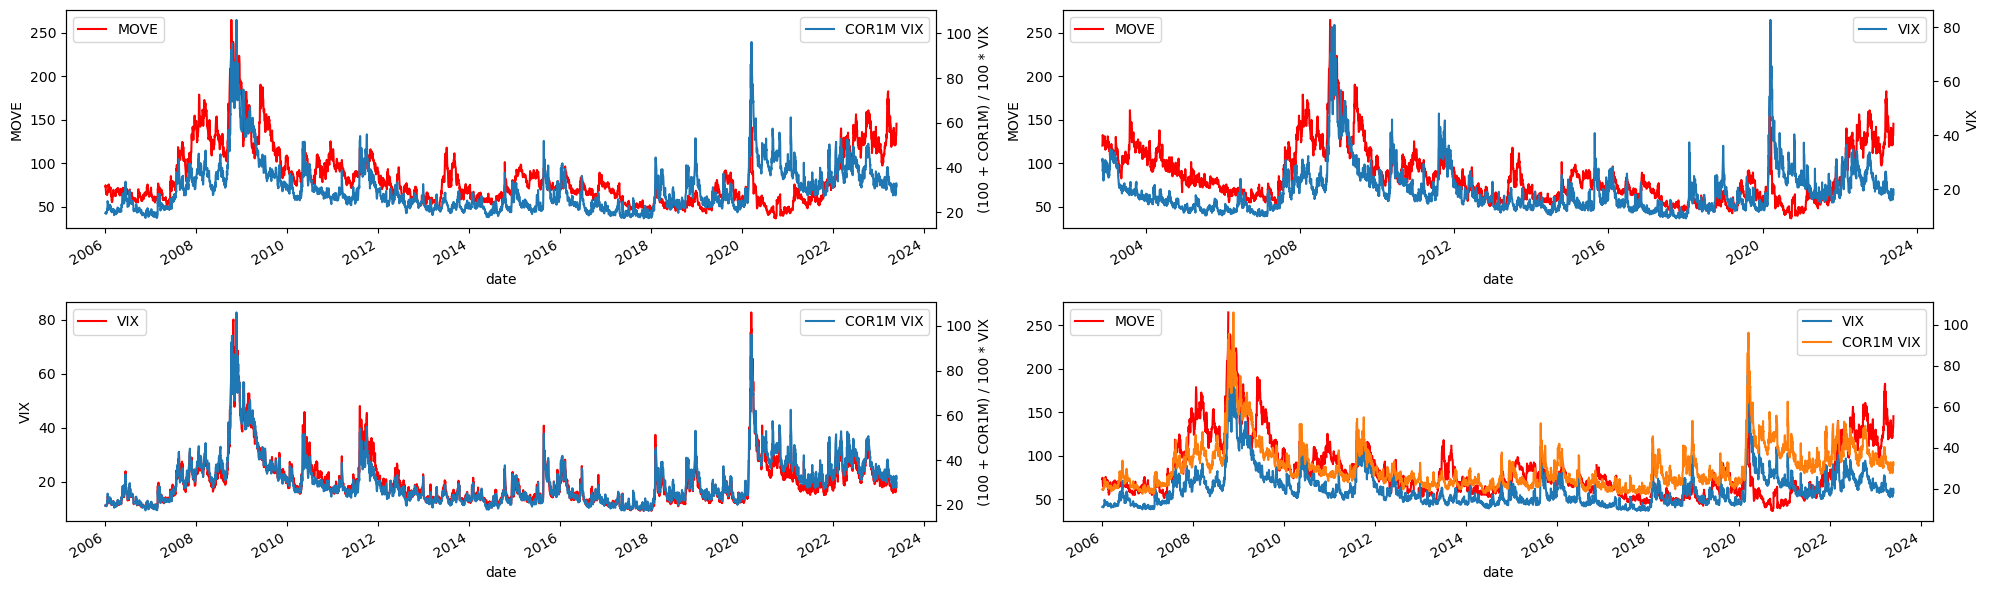

In [126]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20,6))

axes00_copy = axes[0,0].twinx()
(df_combined[
    ["MOVE"]].
    plot(
        ax = axes[0,0],
        ylabel = "MOVE",
        color = "red"))

(df_combined[
    ["new_vol"]].
    rename(columns = {"new_vol": "COR1M VIX"}).
    plot(
        ax = axes00_copy,
        ylabel = "(100 + COR1M) / 100 * VIX"))

(df_yf.pivot(
    index = "date", columns = "variable", values = "value").
    dropna()
    [["MOVE"]].
    plot(
        ax = axes[0,1],
        color = "r",
        ylabel = "MOVE"))

axes01_copy = axes[0,1].twinx()
(df_yf.pivot(
    index = "date", columns = "variable", values = "value").
    dropna()
    [["VIX"]].
    plot(
        ax = axes01_copy,
        ylabel = "VIX"))

axes10_copy = axes[1,0].twinx()
(df_all_three.drop(
    columns = ["MOVE", "new_vol"]).
    plot(
        ax = axes[1,0],
        color = "red",
        ylabel = "VIX"))

(df_all_three.drop(
    columns = ["MOVE", "VIX"]).
    rename(columns = {"new_vol": "COR1M VIX"}).
    plot(
        ax = axes10_copy,
        ylabel = "(100 + COR1M) / 100 * VIX"))

(df_all_three[
    ["MOVE"]].
    plot(
        ax = axes[1,1],
        color = "r"))

axes11_copy = axes[1,1].twinx()
(df_all_three.drop(
    columns = ["MOVE"]).
    rename(columns = {"new_vol": "COR1M VIX"}).
    plot(
        ax = axes11_copy))

axes00_copy.legend(loc = "upper right")
axes[0,0].legend(loc = "upper left")
axes01_copy.legend(loc = "upper right")
axes[0,1].legend(loc = "upper left")
axes10_copy.legend(loc = "upper right")
axes[1,0].legend(loc = "upper left")
axes11_copy.legend(loc = "upper right")
axes[1,1].legend(loc = "upper left")

plt.tight_layout()
plt.show()